In [34]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

In [35]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%d-%m-%Y')
# data = pd.read_csv('AAPL.csv', index_col='Date',parse_dates=['Date'], date_parser=dateparse)
data = pd.read_csv('AAPL.csv',parse_dates=['Date'], date_parser=dateparse)

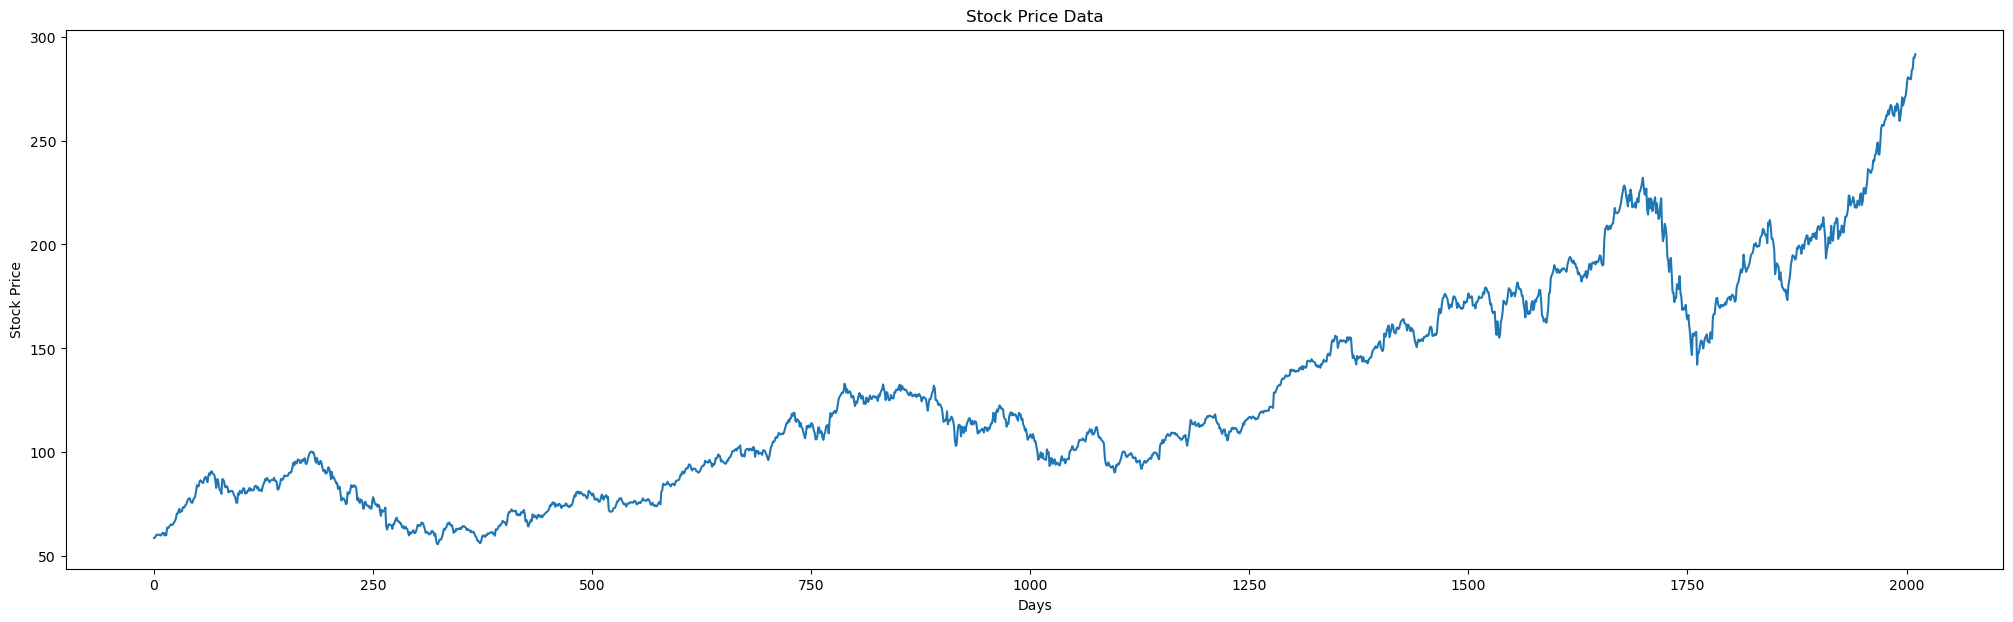

In [36]:
plt.figure(figsize=(25,7))
plt.plot(data["Close"])
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Stock Price Data')
plt.show()

# ARIMA Model
ARIMA is  short for AutoRegressive Integrated Moving Average, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.
ARIMA Models are specified by three order parameters: (p, d, q), where,

p is the order of the AR term

q is the order of the MA term

d is the number of differencing required to make the time series stationary

In [37]:
#stationary test
from statsmodels.tsa.stattools import adfuller
result = adfuller(data["Close"].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.219370
p-value: 0.996117


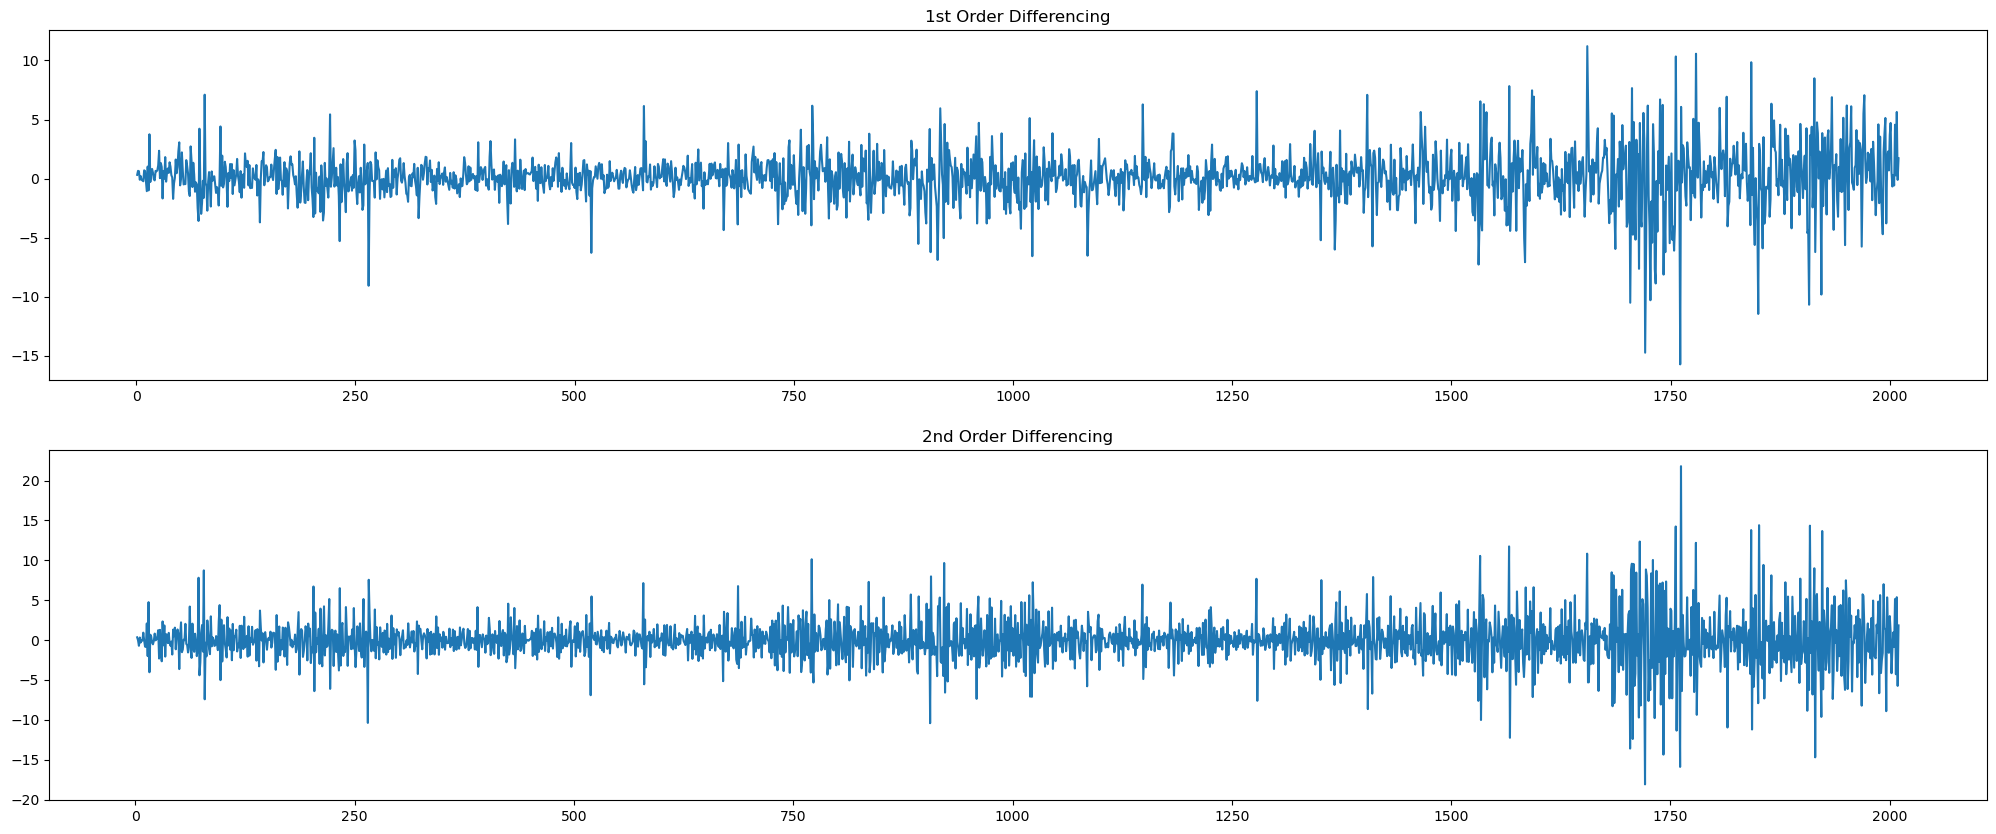

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(25,10))
axes[0].plot(data["Close"].diff()); ax=axes[0].set_title('1st Order Differencing')
axes[1].plot(data["Close"].diff().diff()); ax=axes[1].set_title('2nd Order Differencing')
plt.show()

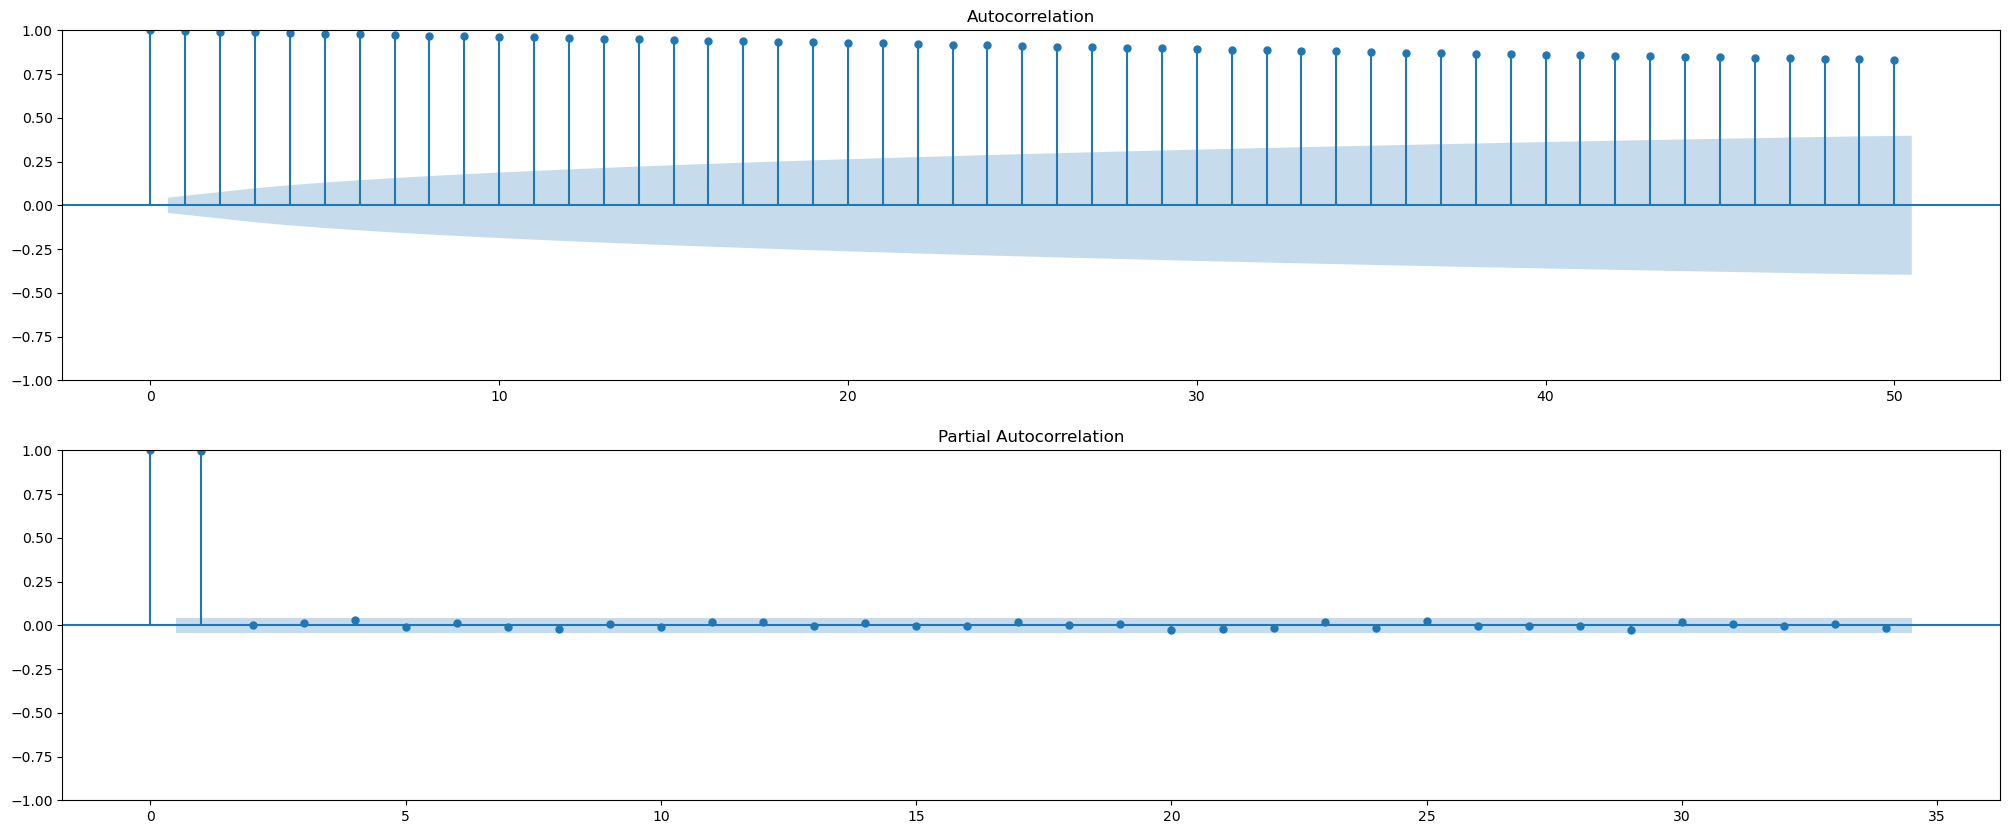

In [39]:
fig, axes = plt.subplots(2, 1, figsize=(25,10))
plot_acf(data["Close"], lags=50, ax=axes[0])
plot_pacf(data["Close"], ax=axes[1])
plt.show()

In [40]:
# Split the data into train and test sets
train_size = int(len(data["Close"]) * 0.9)
train_data, test_data = data["Close"][0:train_size], data["Close"][train_size:]

In [41]:
# Define the range of p, d, and q values to try
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

# Generate all possible combinations of p, d, and q values
pdq_values = list(itertools.product(p_values, d_values, q_values))

# Fit ARIMA models with each combination of p, d, and q values
best_aic = np.inf
best_pdq = None

for pdq in pdq_values:
    try:
        model = ARIMA(train_data, order=pdq)
        results = model.fit()
        aic = results.aic
        if aic < best_aic:
            best_aic = aic
            best_pdq = pdq
    except:
        continue

print('Best (p, d, q) values: {}'.format(best_pdq))

Best (p, d, q) values: (2, 1, 2)


In [42]:
# Fit the ARIMA model
model_arima = ARIMA(train_data, order=(2, 1, 2))
arima_fit = model_arima.fit()

In [43]:
# Predict the stock price for the test data
predictions_arima = arima_fit.forecast(steps=len(test_data))

In [44]:
# Calculate the mean squared error
mse = mean_squared_error(test_data, predictions_arima)
print("Mean Squared Error: ", mse)
# Calculate MAPE
mape = np.mean(np.abs((test_data - predictions_arima) / test_data)) * 100
print("MAPE:", mape)

Mean Squared Error:  2170.9156399198905
MAPE: 15.350033925505018


In [45]:
predictions_arima

1809    181.545026
1810    182.074110
1811    182.728381
1812    182.810051
1813    182.236588
           ...    
2006    181.965070
2007    182.279702
2008    182.502225
2009    182.396363
2010    182.077412
Name: predicted_mean, Length: 202, dtype: float64

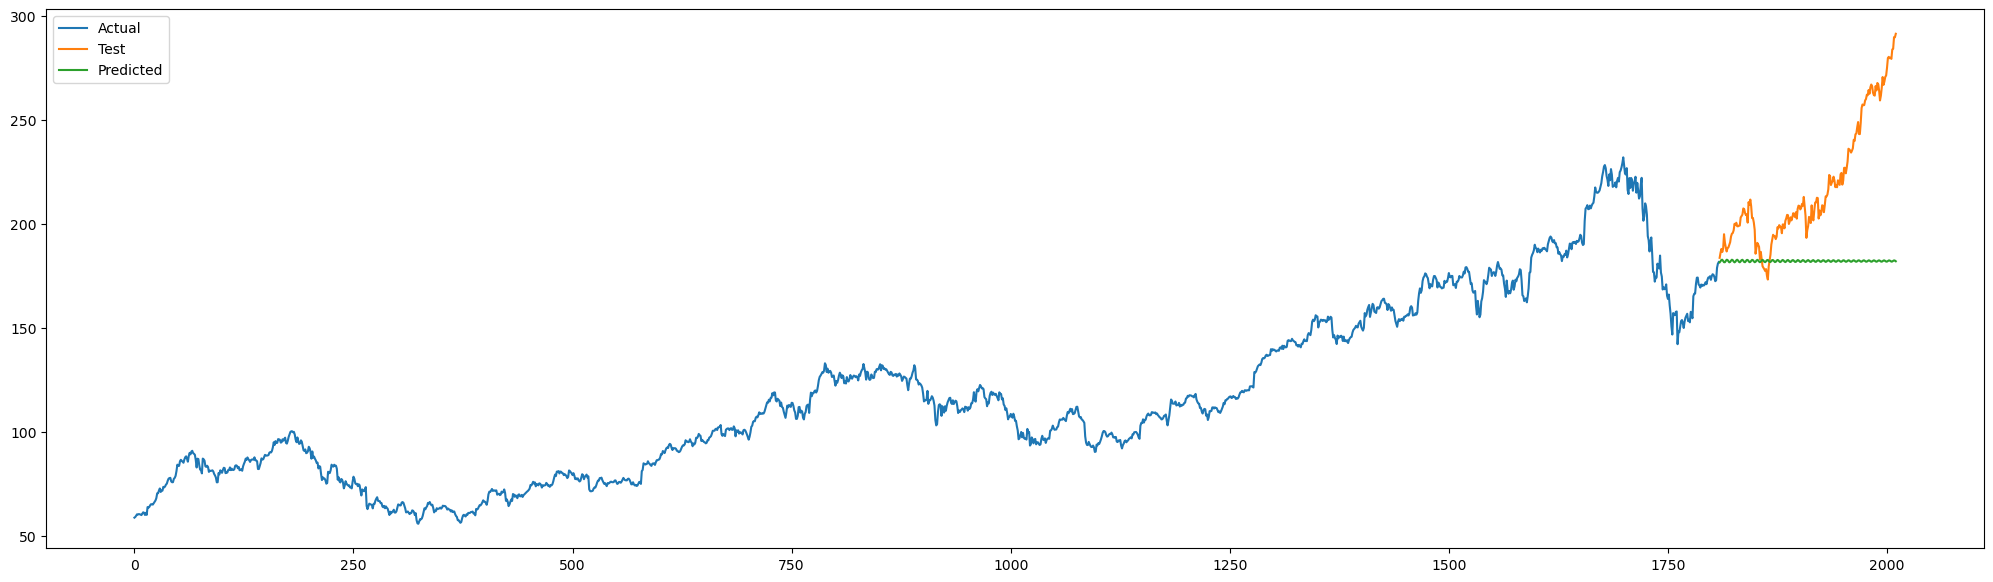

In [46]:
# Plot the actual vs predicted stock prices
plt.figure(figsize=(25,7))
plt.plot(train_data, label="Actual")
plt.plot(test_data, label="Test")
plt.plot(predictions_arima, label="Predicted")
plt.legend()
plt.show()

In [47]:
def evaluate_models(dataset, p_values, d_values, q_values, S_values):
    best_aic, best_mape, best_rmse, best_cfg = float("inf"), float("inf"), float("inf"), None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for S in S_values:
                    order = (p, d, q)
                    seasonal_order = (p, d, q, S)
                    try:
                        aic, mape, rmse = evaluate_sarima_model(dataset, order, seasonal_order)
                        if aic < best_aic and mape < best_mape and rmse < best_rmse:
                            best_aic, best_mape, best_rmse, best_cfg = aic, mape, rmse, order + seasonal_order
                        print('SARIMA{} RMSE={:.3f} AIC={:.3f} MAPE={:.3f}'.format(order + seasonal_order, rmse, aic, mape))
                    except:
                        continue

    print('Best SARIMA{} RMSE={:.3f} AIC={:.3f} MAPE={:.3f}'.format(best_cfg, best_rmse, best_aic, best_mape))

def evaluate_sarima_model(dataset, order, seasonal_order):
    train_size = int(len(dataset) * 0.8)
    train, test = dataset[:train_size], dataset[train_size:]
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    forecast = model_fit.forecast(len(test))
    rmse = np.sqrt(mean_squared_error(test, forecast))
    aic = model_fit.aic
    mape = mean_absolute_percentage_error(test, forecast)
    return aic, mape, rmse

# Define the parameter ranges
# Tried different p,d,q,s values and kept certrain values to run code faster
p_values = [0, 1]
d_values = range(1, 3)
q_values = range(0, 2)
S_values = [5,22]

evaluate_models(data["Close"].values, p_values, d_values, q_values, S_values)

SARIMA(0, 1, 0, 0, 1, 0, 5) RMSE=29.741 AIC=7284.972 MAPE=0.105
SARIMA(0, 1, 0, 0, 1, 0, 22) RMSE=227.114 AIC=7237.706 MAPE=0.973
SARIMA(0, 1, 1, 0, 1, 1, 5) RMSE=26.370 AIC=6184.335 MAPE=0.103
SARIMA(0, 1, 1, 0, 1, 1, 22) RMSE=26.373 AIC=6193.799 MAPE=0.103
SARIMA(0, 2, 0, 0, 2, 0, 5) RMSE=168741.246 AIC=10126.836 MAPE=502.209
SARIMA(0, 2, 0, 0, 2, 0, 22) RMSE=16099.366 AIC=9866.782 MAPE=47.568
SARIMA(0, 2, 1, 0, 2, 1, 5) RMSE=25.360 AIC=7313.280 MAPE=0.095
SARIMA(0, 2, 1, 0, 2, 1, 22) RMSE=344.246 AIC=7266.362 MAPE=1.394
SARIMA(1, 1, 0, 1, 1, 0, 5) RMSE=26.480 AIC=6783.973 MAPE=0.102
SARIMA(1, 1, 0, 1, 1, 0, 22) RMSE=120.606 AIC=6757.386 MAPE=0.520
SARIMA(1, 1, 1, 1, 1, 1, 5) RMSE=26.370 AIC=6187.404 MAPE=0.103
SARIMA(1, 1, 1, 1, 1, 1, 22) RMSE=26.404 AIC=6195.512 MAPE=0.102
SARIMA(1, 2, 0, 1, 2, 0, 5) RMSE=387703.706 AIC=8634.544 MAPE=1152.708
SARIMA(1, 2, 0, 1, 2, 0, 22) RMSE=40912.481 AIC=8580.825 MAPE=127.051
SARIMA(1, 2, 1, 1, 2, 1, 5) RMSE=25.027 AIC=6819.055 MAPE=0.107
SARIMA(

In [48]:
model_sarima = SARIMAX(train_data, order=(0,1,1), seasonal_order=(0,1,1,5))
sarima_fit = model_sarima.fit()

In [49]:
# predictions_sarima = sarima_fit.forecast(steps=30)
# Predict the stock price for the test data
predictions_sarima = sarima_fit.forecast(steps=len(test_data))

In [50]:
predictions_sarima

1809    181.709859
1810    181.807902
1811    181.949828
1812    181.901627
1813    182.061837
           ...    
2006    195.208126
2007    195.159925
2008    195.320135
2009    195.308113
2010    195.406156
Name: predicted_mean, Length: 202, dtype: float64

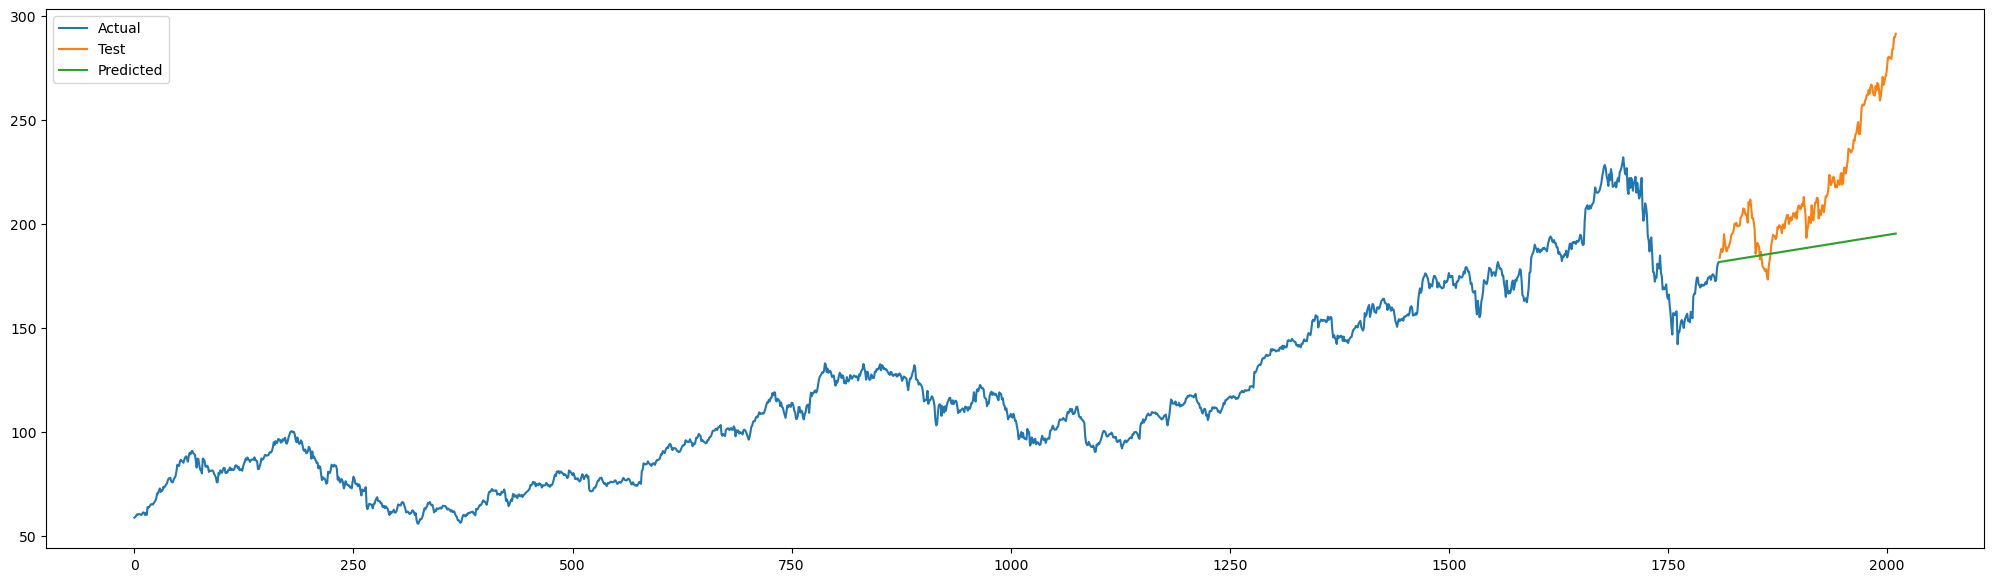

In [51]:
# Plot the actual vs predicted stock prices
plt.figure(figsize=(25,7))
plt.plot(train_data, label="Actual")
plt.plot(test_data, label="Test")
plt.plot(predictions_sarima, label="Predicted")
plt.legend()
plt.show()

In [52]:
final_sarima = SARIMAX(data["Close"], order=(0,1,1), seasonal_order=(0,1,1,5))
final_sarima_fit = final_sarima.fit()

In [53]:
final_pred_sarima = final_sarima_fit.forecast(steps=30)

In [54]:
final_pred_sarima

2011    291.751029
2012    291.758701
2013    291.891062
2014    291.989832
2015    292.120332
2016    292.330468
2017    292.338141
2018    292.470501
2019    292.569271
2020    292.699772
2021    292.909908
2022    292.917580
2023    293.049941
2024    293.148711
2025    293.279211
2026    293.489347
2027    293.497020
2028    293.629381
2029    293.728150
2030    293.858651
2031    294.068787
2032    294.076459
2033    294.208820
2034    294.307590
2035    294.438090
2036    294.648226
2037    294.655899
2038    294.788260
2039    294.887030
2040    295.017530
Name: predicted_mean, dtype: float64

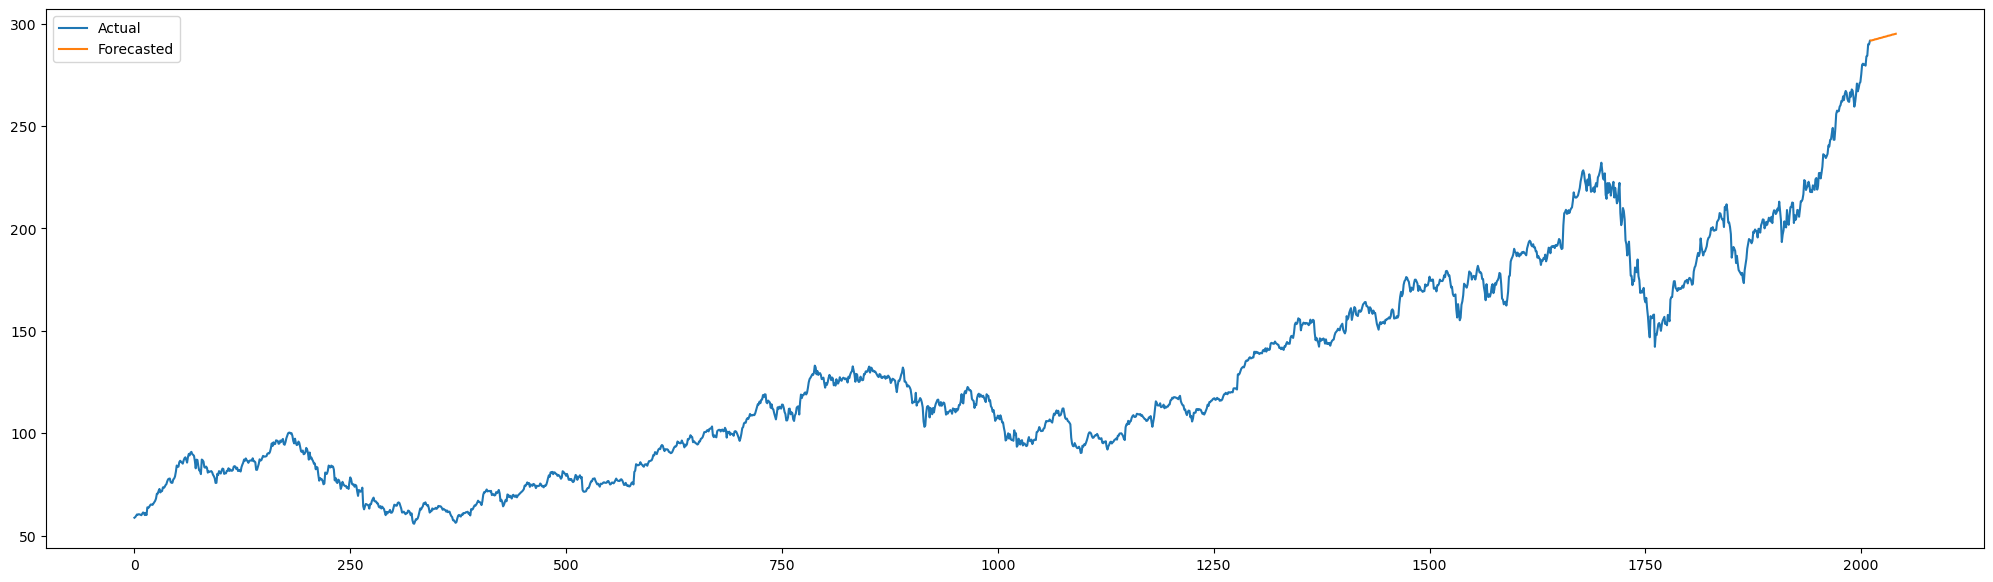

In [58]:
# Plot the actual vs predicted stock prices
plt.figure(figsize=(25,7))
plt.plot(data["Close"], label="Actual")
plt.plot(final_pred_sarima, label="Forecasted")
plt.legend()
plt.show()

In [57]:
import pickle

with open('sarima_model.pkl', 'wb') as f:
    pickle.dump(final_sarima_fit, f)